# Annealed importance sampling

Simulating samples from distributions is a central problem in Statistics and Machine Learning, because it enables estimating important quantities such as integrals.
For example, we are often interested in evaluating integrals of the form

$$\begin{equation}
I = \int p(x) f(x) dx,
\end{equation}$$

where $p$ is a probability density and $f$ is a function of interest.
If we have acccess to the cumulative density function $p$, we can easily draw samples from it using [inverse transform sampling](https://en.wikipedia.org/wiki/Inverse_transform_sampling).
However, in most cases, the cumulative density function does not have an analytically tractable closed form, so sampling via the inverse transform does not apply.
For example, non-conjugate Bayesian models typically involve intractable distributions of this kind.
In such cases, we must resort to approximation methods, such as Monte Carlo.

A standard Monte Carlo method for handling intractable integrals is importance sampling.
Importance sampling gets around the intractability of $p$ by introducing another tractable distribution $q$ and drawing samples from $q$ insted of $p$.
It then corrects for the bias in the samples, to account for the fact that these now come from $q$ rather than $p$, by weighing them appropriately, using so called importance weights.
In this way, importance sampling yields an unbiased estimate of downstream integrals, while circumventing the intractability of $p$.

Unfortunately, if $q$ and $p$ are very dissimilar, the importance sampling estimator has a large random error because, as we will see, the variance in the random weights is large.
Annealed importance sampling{cite}`neal2001annealed` is a method which circumvents this issue by using an annealing procedure which produces samples with more equally distributed importance weights while remaining unbiased, and can greatly reduce the variance of the resulting estimates.

## Importance sampling

Suppose we wish to evaluate an integral of the form

$$\begin{equation}
I = \int p(x) f(x) dx.
\end{equation}$$

If we could draw samples from $p$, we could estimate this integral by Monte Carlo, by computing

$$\begin{equation}
I \approx \frac{1}{N} \sum_{n=1}^N f(x_n) ~~\text{ where }~~ x_n \sim p.
\end{equation}$$

However, in many applications of interest, we cannot draw samples from $p$ directly.
Importance sampling gets around this by introducing another tractable distribution $q$, and rewriting this integral as 

$$\begin{equation}
I = \int q(x) \frac{p(x)}{q(x)} f(x) dx.
\end{equation}$$

A technical, but important, requirement here is that $q$ should be non-zero whenever $p$ is non-zero, for the integral above to be well defined.
Hereafter we assume this to be the case.
Since the distribution $q$ is tractable, we can estimate the value of the integral by drawing samples from it and computing

$$\begin{equation}
I \approx \frac{1}{N} \sum_{n=1}^N \underbrace{\frac{p(x_n)}{q(x_n)}}_{w_n} f(x_n) ~~\text{ where }~~ x_n \sim q.
\end{equation}$$

The ratios $w_n$ are called importance weights, since they weigh the contribution of each $f(x_n)$ term in the sum.
Since $q$ proposes the samples to be used in the Monte Carlo sum, it is commonly referred to it as the proposal distribution.
We also refer to $p$ as the target distribution, since this is the one we are ultimately interested in.
This is called the importance sampling estimator, and is unbiased, meaning that in expectation it is equal to the original integral

$$\begin{equation}
\mathbb{E}\left[ \frac{1}{N} \sum_{n=1}^N \frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{1}{N} \sum_{n=1}^N \mathbb{E}\left[\frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{1}{N} \sum_{n=1}^N I = I.
\end{equation}$$

However, in practice we always end up using a finite number of samples, so the importance sampling estimate will not be exactly equal to $I$, but will be off by some random error, whose magnitude is captured by the variance of the estimator.
In particular, if the variance of the estimator using a single sample is $V$, that is

$$\begin{equation}
V = \mathbb{V}\left[\sum_{n=1}^N \frac{p(x_n)}{q(x_n)} f(x_n) \right] \geq 0,
\end{equation}$$

then using $N$ samples reduces the variance by a factor of $N$

$$\begin{equation}
\mathbb{V}\left[\frac{1}{N}\sum_{n=1}^N \frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{1}{N^2}\mathbb{V}\left[\sum_{n=1}^N \frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{1}{N^2}\sum_{n=1}^N \mathbb{V}\left[\frac{p(x_n)}{q(x_n)} f(x_n) \right] = \frac{V}{N}.
\end{equation}$$

Using more samples reduces the overall variance, but increases the computational cost.
A common issue that arises with the importance sampling estimator is that its variance, $V$, can be very large.
This means that lots of samples, and thus lots of computate, must be used to obtain a reasonable estimate.

In [44]:
from typing import *

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
dtype = tf.float64

import matplotlib
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats('pdf', 'svg')

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

Let's look at a simple example of Importance Sampling.
Suppose $f(x) = x^3$ and let $p$ be a mixture of Gaussians

$$\begin{equation}
p(x) = \pi \mathcal{N}(x; \mu_1, \sigma_1^2) + (1 - \pi) \mathcal{N}(x; \mu_2, \sigma_2^2).
\end{equation}$$

Of course, we can in fact draw samples from a mixture of Gaussians directly, but let's pretend we can't.
Now, define $q$ to be a Gaussian

$$\begin{equation}
q(x) = \mathcal{N}(x; \mu_q, \sigma_q^2).
\end{equation}$$

In [45]:
f = lambda x: x**3.

x_plot = tf.cast(tf.linspace(-4., 4., 200), dtype=dtype)

m1 = tf.convert_to_tensor(-2., dtype=dtype)
s1 = tf.convert_to_tensor(0.4, dtype=dtype)

m2 = tf.convert_to_tensor(2., dtype=dtype)
s2 = tf.convert_to_tensor(0.4, dtype=dtype)

mq = tf.convert_to_tensor(0., dtype=dtype)
sq = tf.convert_to_tensor(0.8, dtype=dtype)

mix_probs = tf.convert_to_tensor([0.5, 0.5], dtype=dtype)

p1 = tfd.Normal(loc=m1, scale=s1)
p2 = tfd.Normal(loc=m2, scale=s2)

p = tfd.Mixture(cat=tfd.Categorical(probs=mix_probs), components=[p1, p2])
q = tfd.Normal(loc=mq, scale=sq)

p_plot = tf.math.exp(p.log_prob(x_plot))
q_plot = tf.math.exp(q.log_prob(x_plot))
f_plot = f(x_plot)

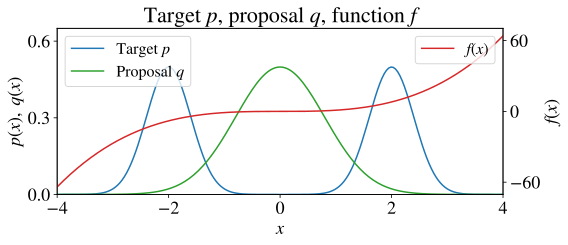

In [46]:
plt.figure(figsize=(8, 3))

# Plot proposal
plt.plot(
    x_plot,
    p_plot,
    color="tab:blue",
    label="Target $p$",
)

# Plot target
plt.plot(
    x_plot,
    q_plot,
    color="tab:green",
    label="Proposal $q$",
)

plt.title("Target $p$, proposal $q$, function $f$", fontsize=22)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$p(x),~ q(x)$", fontsize=18)

plt.xticks(tf.linspace(-4., 4., 5), fontsize=18)
plt.yticks(tf.linspace(0., 0.6, 3), fontsize=18)

plt.xlim([-4., 4.])
plt.ylim([0, 0.65])

plt.legend(loc="upper left", fontsize=16)

twin_axis = plt.gca().twinx()

plt.plot(
    x_plot,
    f_plot,
    color="tab:red",
    label="$f(x)$",
)

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)

plt.legend(loc="upper right", fontsize=16)
plt.yticks(tf.linspace(-60., 60., 3), fontsize=18)

plt.show()

Using importance sampling, we can obtain an estimate of this intergral.

In [47]:
# Set the random seed for repeatable results
tf.random.set_seed(0)

# How many samples to draw
num_samples = 100

# Draw samples
samples = q.sample([num_samples])

# Compute importance weights and importance weighted integral
w = tf.math.exp(p.log_prob(samples) - q.log_prob(samples))
I = tf.reduce_mean(w * f(samples))

print(f"Importance Sampling estimate I = {I:.2f}")

Importance Sampling estimate I = -5.40


Note that the exact value of the integral is $I = 0$, which we can see because $p(x)$ is symmetric around $x = 0$ while $f(x) = x^3$ is antisymmetric.
However the estimate was $I \approx -5.46$ which seems a bit off.
Repeating this experiment $100$ times we obtain:

In [48]:
# How many samples to draw
num_samples = 100
num_trials = 100
    
# Draw samples
samples = q.sample([num_trials, num_samples])

# Compute importance weights and importance weighted integral
w = tf.math.exp(p.log_prob(samples) - q.log_prob(samples))
I = tf.reduce_mean(w * f(samples), axis=1)

mean_I = tf.reduce_mean(I)
std_I = tf.math.reduce_std(I)

print(
    f"Importance Sampling over {num_trials} trials "
    f"I = {mean_I:.2f} +/- {2.*std_I:.3f}."
)

Importance Sampling over 100 trials I = 0.10 +/- 13.309.


So even though the estimator is unbiased, it has a large variance.
Before we go further, let's compare the importance sampling estimate to a Monte Carlo estimate using samples directly from $p$.
Note that in practice this is not possible, because $p$ is not in general available in closed form, but that's why we picked $p$ to be a mixture of Gaussians.
The point of this additional Monte Carlo estimate is to give us an idea of how much random error we should expect if we had access to exact samples from $p$, which we cannot expect to beat by simply reducing the variance in the importance weights.

In [49]:
# How many samples to draw
num_samples = 100
num_trials = 100
    
# Draw samples
px = q.sample([num_trials, num_samples])

# Compute importance weights and importance weighted integral
I = tf.reduce_mean(w * f(px), axis=1)

mean_I = tf.reduce_mean(I)
std_I = tf.math.reduce_std(I)

print(
    f"Monte Carlo with samples from p over {num_trials} trials "
    f"I = {mean_I:.2f} +/- {2.*std_I:.3f}."
)

Monte Carlo with samples from p over 100 trials I = -0.07 +/- 1.848.


The Importance sampling estimator has seven times larger random error than the Monte Carlo estimator.
To see why, this occurs, let's plot the raw samples drawn from $q$ (in green) as well as the samples weighted according to their importance weights (in blue).

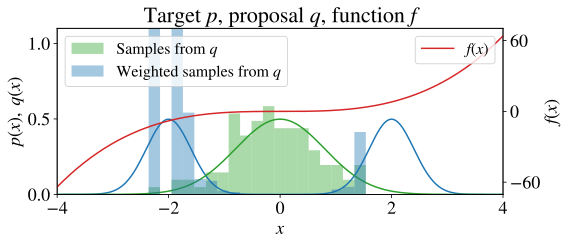

In [50]:
# Set the random seed for repeatable results
tf.random.set_seed(0)

# How many samples to draw
num_samples = 100

# Draw samples and compute importance weights
samples = q.sample([num_samples])
w = tf.math.exp(p.log_prob(samples) - q.log_prob(samples))

plt.figure(figsize=(8, 3))

# Plot proposal
plt.plot(x_plot, p_plot, color="tab:blue")

# Plot target
plt.plot(x_plot, q_plot, color="tab:green")

# Plot raw samples
plt.hist(
    samples,
    density=True,
    color="tab:green",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=1,
    label="Samples from $q$"
)

# Plot samples weighted by their importance weights
plt.hist(
    samples,
    weights=w,
    density=True,
    color="tab:blue",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=2,
    label="Weighted samples from $q$"
)

plt.title("Target $p$, proposal $q$, function $f$", fontsize=22)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$p(x),~ q(x)$", fontsize=18)

plt.xticks(tf.linspace(-4., 4., 5), fontsize=18)
plt.yticks(tf.linspace(0., 1.0, 3), fontsize=18)

plt.xlim([-4., 4.])
plt.ylim([0, 1.1])

plt.legend(loc="upper left", fontsize=16)

twin_axis = plt.gca().twinx()

# Plot function
plt.plot(x_plot, f_plot, color="tab:red", label="$f(x)$")

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)

plt.legend(loc="upper right", fontsize=16)
plt.yticks(tf.linspace(-60., 60., 3), fontsize=18)

plt.show()

First off, this plot illustrates how importance sampling works.
Although $q$ proposes many samples in the middle, these are down-weighted by the importance weights, since $p$ has small density there.
Note that the samples in the middle are still there in the blue histogram, but they have just been down-weighted by the importance weights.
Conversely, whenever $q$ proposes a sample at a point where $p$ has high density, the importance weight becomes much larger.
In this way, importance sampling moulds the empirical distribution of samples from $q$ (in green) to resemble the target distribution $p$ (in blue).

However, the samples which receive a high importance are relatively infrequent, which means that sometimes we may get sample with a large importance weight in one of the two Gaussian modes, but not in the other mode.
Since this sample has a large importance weight, it greatly affects the overall estimate, introducing lots of random error.
Looking at a histogram of the importance weights we see that most weights are very small, and it's only a few large weights which dominate the value of the integral (note the $x$-axis has a log-scale).

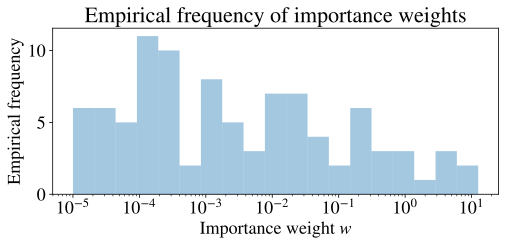

In [51]:
# Plot distributions and samples
plt.figure(figsize=(8, 3))

# Plot importance weights
plt.hist(
    w,
    density=False,
    color="tab:blue",
    alpha=0.4,
    bins=10**tf.linspace(-5., 1.1, 20),
    zorder=2,
    label="Importance weights",
)

plt.title("Empirical frequency of importance weights", fontsize=22)

plt.xlabel("Importance weight $w$", fontsize=18)
plt.ylabel("Empirical frequency", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks([0, 5, 10], fontsize=18)

plt.xscale("log")

plt.show()

Going a little further, note that the expectation of the value of an importance weight is always equal to one since

$$\begin{equation}
\int q(x) \frac{p(x)}{q(x)} dx = 1 \implies \mathbb{E}_{x \sim q(x)}\left[\frac{p(x)}{q(x)} \right] = 1,
\end{equation}$$

This means that if $q$ proposes samples with small importance weights most of the time, it must also propose some samples with very large importance weights to make up for the small importance weights: the integrand cannot always be smaller than $1$ or always larger than $1$, otherwise it would not integrate to $1$.
The quantity which affects the amount of random error in an importance sampling estimator is the variability of the importance weights around this mean, that is the variance of the importance weights.
It is reasonable to expect that the more dissimilar $q$ and $p$ are, the larger the variance will be.
In partricular, we can show that the variance of the importance weights can be lower bounded by a quantity that scales exponentially with the KL divergence.

:::{prf:lemma} Lower bound to importance weight variance

Given distributions $p$ and $q$, it holds that
    
$$\begin{equation}
\mathbb{V}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] \geq e^K - 1, \text{ where } K = \max\left(D_{KL}(p || q),~ 2 D_{KL}(q || p)\right) 
\end{equation}$$
    
where $D_{KL}$ denotes the Kullback-Leibler diverence, measured in nats.
    
:::


:::{dropdown} Derivation (Lower bound to importance weight variance)
    
The variance in the importance weights can be written as

$$\begin{align}
\mathbb{V}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] &= \mathbb{E}_{x \sim q}\left[\left(\frac{p(x)}{q(x)}\right)^2\right] - \mathbb{E}_{x \sim q}\left[\frac{p(x)}{q(x)}\right]^2, \\
&= \mathbb{E}_{x \sim q}\left[\left(\frac{p(x)}{q(x)}\right)^2\right] - 1, \\
&= \mathbb{E}_{x \sim p}\left[\frac{p(x)}{q(x)}\right] - 1, \\
\end{align}$$

By applying Jensen's inequality once, we can get a lower bound to the expectation above, to obtain

$$\begin{align}
\mathbb{V}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] &= \exp\left(\log\left(\mathbb{E}_{x \sim q}\left[\frac{p(x)^2}{q(x)^2}\right] \right)\right) - 1 \\
&\geq \exp\left(\mathbb{E}_{x \sim p}\left[2 \log \frac{p(x)}{q(x)} \right]\right) - 1 \\
&= e^{2 D_{KL}(q || p)} - 1,
\end{align}$$
    
and similarly

$$\begin{align}
\mathbb{V}_{x \sim q}\left[\frac{p(x)}{q(x)}\right] &= \exp\left(\log\left( \mathbb{E}_{x \sim p}\left[\frac{p(x)}{q(x)}\right] \right)\right) - 1 \\
&\geq \exp\left(\mathbb{E}_{x \sim p}\left[\log \frac{p(x)}{q(x)} \right]\right) - 1 \\
&= e^{D_{KL}(p || q)} - 1,
\end{align}$$

which is the lower bound in the lemma.
    
:::

Note that when $q = p$, this lower bound becomes $0$.
This is in agreement with the fact that when $q = p$, all importance weights are equal to $1$ and their variance is $0$.
As $q$ becomes more and more dissimilar to $p$, $D_{KL}(q || p)$ increases and so does the lower bound.
Therefore the variance also increases and in fact it increases at least exponentially with $D_{KL}(q || p)$.
Of course, this is only a lower bound, and the actual variance can be even larger than this.
On the flipside, this lower bound tells us that if we want to reduce the variance in the importance weights we must draw our samples from a proposal distribution which is as similar as possible with the target distribution, in the sense of having a small KL divergence.

This is where Annealed Importance Sampling (AIS) becomes useful.
AIS is an importance sampling method which uses an annealing procedure based on Markov Chain Monte Carlo (MCMC), to produce samples whose distribution is closer to $p$.
To achieve this, instead of using samples from $q$ directly in the importance sampling estimator, AIS gradually transforms the samples, such that the distribution of the transformed samples is closer to $p$.
This reduces the variability in the importance samples and thus the random error in the importance sampling estimator.

## Importance-weighted MCMC

Motivated by the above intuition, given some initial samples from $q$, we want to transform them in a way such that the distribution of the transformed samples is as close as possible to $p$.
This would reduce the variance of the importance weights and thus the error in our estimator.
Markov Chain Monte Carlo (MCMC) is a standard class of methods geared towards solving this type of problem: an MCMC algorithm begins from an arbitrarily initialised distribution, and proceeds to transform this distribution acording to a randomised rule, such that the resulting distribution is closer to a target distribution.
So we could, in principle, use MCMC within an importance-weighted estimator to reduce its variance.
The following algorithm is based on this intuition.


:::{prf:definition} Importance weighted MCMC algorithm

Given a proposal density $q$, a target density $p$ and a sequence of transition kernels $T_1(x, x'), \dots, T_K(x, x')$ be a sequence of transition kernels such that $T_k$ leaves $p$ invariant.
Sampling $x_0 \sim q(x)$ followed by
    
$$\begin{equation}
x_k \sim T_k(x_{k-1}, x_k) ~\text{ for }~ k = 1, \dots, K,
\end{equation}$$
    
and return the sample $x_K$ with an appropriately chosen importance weight $w$ such that the resulting estimator is unbiased.
    
:::

Note that the only requirement on the transition kernels $T_k(x, x')$ is that they leave $p$ invariant, and do not need to result in an ergodic Markov Chain, which is a usual requirement in standard MCMC.
The distribution which results after drawing an intial sample drawn from the proposal $q$ and applying the transition kernels $T_1(x, x'), \dots, T_K(x, x')$ can be written as

$$\begin{align}
q_K(x_K) = \int q(x_0) T_1(x_0, x_1) \dots T_K(x_{K-1}, x_K) dx_0 \dots dx_{K-1},
\end{align}$$

and gets closer to $p$ as we increase $K$.
Note that this algorithm does not specify how to select $w$.
However, while we could in principle draw $x_K \sim q_K$ and return this sample together with the importance weight

$$\begin{align}
w = \frac{p(x_K)}{q_K(x_K)},
\end{align}$$

each of the nested integrals above is intractable, which means we cannot compute $q_K$ in closed form, and by extension we cannot compute $w$ in closed form either.
One way to get around this issue, is to consider the joint distribution of $(x_0, x_1, \dots, x_K)$ under the Markov Chain, which has density

$$\begin{align}
h(x_0, x_1, \dots, x_K) = q(x_0) T_1(x_0, x_1) \dots T_K(x_{K-1}, x_K).
\end{align}$$

We can then define the reverse transition kernels $\tilde{T}_k$ as

$$\begin{align}
\tilde{T}_k(x, x') = T_k(x', x)\frac{p(x')}{p(x)}.
\end{align}$$

Because $T_k$ leaves $p$ invariant, it holds that

$$\begin{align}
\int \tilde{T}_k(x, x') dx' = \int T_k(x', x)\frac{p(x')}{p(x)} dx' = \frac{1}{p(x)}\int T_k(x', x)p(x') dx' = 1,
\end{align}$$

so the reverse kernels integrate to $1$ and are also valid transition kernels.
We can now consider a reversed Markov chain which starts with the target distribution $p$ as its intial distribution and applies the reverse kernels $\tilde{T}_k$.
This Markov chain has corresponding joint distribution

$$\begin{align}
\tilde{h}(x_0, x_1, \dots, x_K) = p(x_K) \tilde{T}_K(x_K, x_{K-1}) \dots \tilde{T}_1(x_1, x_0).
\end{align}$$

Now, consider performing importance sampling in this augmented space, with $h$ as the proposal and $\tilde{h}$ as the target distributions.
Specifically, we draw draw $(x_{n, 0}, \dots, x_{n, K}) \sim h$ for $n = 1, \dots, N$ and compute the importance weight

$$\begin{align}
w_n = \frac{\tilde{h}(x_{n, 0}, \dots, x_{n, K})}{h(x_{n, 0}, \dots, x_{n, K})}.
\end{align}$$

The importance weights $w_n$ ensure that for any function $g$ of the augmented sample, the importance weighted estimator

$$\begin{align}
\int g(x_0, \dots, x_K) \tilde{h}(x_0, \dots, x_K) dx_0 \dots dx_K \approx \frac{1}{N}\sum_{n=1}^N w_n g(x_{n, 0}, \dots, x_{n, K}),
\end{align}$$

is unbiased.
Therefore, if we set $g(x_{n, 0}, \dots, x_{n, K}) = f(x_{n, K})$, we obtain the estimator

$$\begin{align}
\int f(x_K) p(x_K) dx_K \approx \frac{1}{N}\sum_{n=1}^N w_n g(x_{n, 0}, \dots, x_{n, K}),
\end{align}$$

which is also unbiased.
Crucially, the importance weights $w_n$ can now be computed in closed form.
Using the definition of the reverse transition kernels we have

$$\begin{align}
p(x_K) \tilde{T}_K(x_K, x_{K-1}) \dots \tilde{T}_1(x_1, x_0) = p(x_0) T_1(x_0, x_1) \dots T_K(x_{K-1}, x_K).
\end{align}$$

and all terms coming from the transition kernels cancel in the importance weight ratio, yielding

$$\begin{align}
w_n = \frac{\tilde{h}(x_{n, 0}, \dots, x_{n, K})}{h(x_{n, 0}, \dots, x_{n, K})} = \frac{p(x_0)}{q(x_0)}.
\end{align}$$

By performing importance sampling in this augmented space, we have got around the issue of intractable importance weights, by cancelling out a load of terms.
However, unfortunately these importance weight are exactly the same as the importance weights of the standard importance sampling estimator, so this algorithm does not improve on the variance of the standard estimator at all! However, it is possible to modify this algorithm to obtain better importance weights, while still taking advantage of the cancellation of the transition kernels.

## Annealed Importance Sampling

Given a sequnece $0 = \beta_0 \leq \dots \leq \beta_K = 1$, AIS introduces a sequence of distributions with densities
    
$$\begin{equation}
\pi_k(x) = p(x)^{\beta_k} q(x)^{(1 - \beta_k)}.
\end{equation}$$

These distributions interpolate between $q$ and $p$ as we vary $\beta$.
AIS then proceeds in a similar way to the importance weighted MCMC algorithm we highlighted above, except that it requires that each $T_k$ leaves $\pi_k$, instead of $p$, invariant.

:::{prf:definition} Annealed Importance Sampling

Given a target density $p$, a proposal density $q$ and a sequence $0 = \beta_0 \leq \dots \leq \beta_K = 1$, define
    
$$\begin{equation}
\pi_k(x) = p(x)^{\beta_n} q(x)^{(1 - \beta_k)},
\end{equation}$$
    
and let $T_1(x, x'), \dots, T_K(x, x')$ be a sequence of transition kernels such that $T_k$ leaves $\pi_k$ invariant.
Annealed Impoprtance Sampling amounts to drawing $x_0 \sim \pi_0(x)$ followed by
    
$$\begin{equation}
x_k \sim T_k(x_{k-1}, x_k) ~\text{ for }~ k = 1, \dots, K,
\end{equation}$$
    
and return the sample $x_K$ together with the importance weight
    
$$\begin{equation}
w = \frac{\pi_1(x_1)}{\pi_0(x_1)} \dots \frac{\pi_K(x_K)}{\pi_{K-1}(x_K)}.
\end{equation}$$
    
:::

Note that drawing samples according to this algorithm and setting $g(x_{n, 0}, \dots, x_{n, K}) = f(x_K)$ still results in an unbiased estimator of $I$.
This is because the augmented sample $(x_{n, 0}, \dots, x_{n, K})$ is distributed acccording to $h$ whose marginal, after integrating out all but the last variable, is $q$.
Let's implement this and see how it performs.

### Implementation

To implement this procedure, we need to specify the transition kernels, and the sequence of annealing parameters $\beta_k$.
For the transition kernel, we will use a standard [Metropolis-Hastings](https://en.wikipedia.org/wiki/Metropolis-Hastings_algorithm) transition kernel, which itself uses a Gaussian distribution as its proposal distribution (not to be confused with the initial proposal distribution $p$).
We'll leave the $\beta_k$ to be specified by the user.

In [52]:
class TransitionKernel:
    
    def __init__(self):
        pass
        
    def __call__(self, x: tf.Tensor):
        pass

    
class GaussianTransitionKernel(TransitionKernel):
    
    def __init__(self, scale: tf.Tensor):
        
        self.scale = scale
        
    def __call__(self, x: tf.Tensor, distribution: tf.Tensor):
        
        # Create forward proposal distribution and propose next point
        forward = tfd.Normal(loc=x, scale=self.scale)
        next_x = forward.sample()
        
        # Create reverse proposal distribution
        reverse = tfd.Normal(loc=next_x, scale=self.scale)
        
        # Compute acceptance probability
        log_prob_1 = forward.log_prob(next_x) + distribution(next_x)
        log_prob_2 = reverse.log_prob(x) + distribution(x)
        
        log_prob_ratio = log_prob_1 - log_prob_2
        p = tf.math.exp(tf.reduce_min([0., log_prob_ratio]))
        
        # Accept reject step
        accept = tf.random.categorical(
            [[tf.math.log(1. - p), tf.math.log(p)]],
            num_samples=1,
            dtype=tf.int32
        )[0, 0]
        
        x_accept = tf.convert_to_tensor([x, next_x])[accept]
        
        return x_accept, accept

We can then put together an `AnnealedImportanceSampler`, which accepts an initial and a target distribution, a transition kernel and a list containing a schedule for $\beta_k$, to perform AIS.

In [53]:
class AnnealedImportanceSampler:
    
    def __init__(
            self,
            initial_distribution: tfd.Distribution,
            target_distribution: tfd.Distribution,
            transition_kernel: TransitionKernel,
            betas: List[float],
        ):
        
        self.initial_distribution = initial_distribution
        self.target_distribution = target_distribution
        self.transition_kernel = transition_kernel
        
        self.betas = betas
        self.num_steps = betas.shape[0]
        
    def __call__(self, num_samples: int) -> List[tf.Tensor]:
        
        # Draw samples from intial distribution
        x0 = self.initial_distribution.sample([num_samples])
        
        # Run AIS chain on the initial samples
        samples_and_log_weights = tf.map_fn(self.run_chain, x0)
        
        return x0, samples_and_log_weights

    @tf.function(jit_compile=True)
    def run_chain(self, x: tf.Tensor, *args) -> tf.Tensor:
        
        # Initialise chain history and current distribution
        chain_history = [x]
        annealed_log_prob = self.initial_distribution.log_prob
        
        # Initialise log importance weight
        log_w = - annealed_log_prob(x)
        
        for i in tf.range(self.num_steps):
            
            # Create next annealed distribution
            next_annealed_log_prob = self.log_geometric_mixture(
                beta=betas[i],
            )
            log_w = log_w + next_annealed_log_prob(x)
            
            # Propose next point
            x, accept = self.transition_kernel(
                x=x,
                distribution=next_annealed_log_prob,
            )
            
            log_w = log_w - next_annealed_log_prob(x)
            
            annealed_log_prob = next_annealed_log_prob
            chain_history.append(x)
            
        log_w = log_w + self.target_distribution.log_prob(x)
        
        return tf.convert_to_tensor([x, log_w], dtype=tf.float64)
            
        
    def log_geometric_mixture(self, beta: tf.Tensor) -> Callable:
        
        def _log_geometric_mixture(x: tf.Tensor) -> tf.Tensor:
            
            log_prob_1 = self.initial_distribution.log_prob(x)
            log_prob_2 = self.target_distribution.log_prob(x)
            
            return ((1. - beta) * log_prob_1 + beta * log_prob_2)
        
        return _log_geometric_mixture

### Toy experiment

Now we have an AIS sampler which can be used with arbitrary annealing parameters $\beta_k$.
For this example, let's set

$$\begin{equation}
\beta_k = \frac{1}{1 + e^{\gamma_k}},
\end{equation}$$

where we start from large and negative values to large and positive values.
This gives $\beta_k$ which gradually interpolate from $0$ to $1$.

In [59]:
dtype = tf.float64

transition_scale = tf.convert_to_tensor(0.3, dtype=dtype)

# Intialise transition kernel
transition_kernel = GaussianTransitionKernel(
    scale=transition_scale
)

# Initialise betas
betas = tf.nn.sigmoid(10. * (tf.cast(tf.linspace(1e-3, 1., 1000), dtype=dtype) - 0.5))

# Initialise AIS sampler
sampler = AnnealedImportanceSampler(
    initial_distribution=q,
    target_distribution=p,
    transition_kernel=transition_kernel,
    betas=betas,
)

Let's draw some samples on the same problem we considered earlier, and visualise them as before.

In [60]:
# Set the random seed for repeatable results
tf.random.set_seed(0)

# How many samples to draw
num_samples = 100

# Draw samples and compute importance weights
x0, samples_and_log_weights = sampler(num_samples=num_samples)

samples = samples_and_log_weights[:, 0]
log_w = samples_and_log_weights[:, 1]

w = tf.math.exp(log_w)

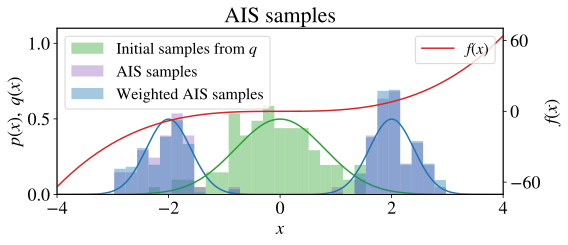

In [61]:
plt.figure(figsize=(8, 3))

# Plot proposal
plt.plot(x_plot, p_plot, color="tab:blue")

# Plot target
plt.plot(x_plot, q_plot, color="tab:green")

# Plot initial samples
plt.hist(
    x0,
    density=True,
    color="tab:green",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=1,
    label="Initial samples from $q$",
)

# Plot samples after samples
plt.hist(
    samples,
    density=True,
    color="tab:purple",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=1,
    label="AIS samples",
)

# Plot samples weighted by their importance weights
plt.hist(
    samples,
    weights=w,
    density=True,
    color="tab:blue",
    alpha=0.4,
    bins=tf.linspace(-4., 4., 40),
    zorder=2,
    label="Weighted AIS samples",
)

plt.title("AIS samples", fontsize=22)
plt.xlabel("$x$", fontsize=18)
plt.ylabel("$p(x),~ q(x)$", fontsize=18)

plt.xticks(np.linspace(-4., 4., 5), fontsize=18)
plt.yticks(np.linspace(0., 1.0, 3), fontsize=18)

plt.xlim([-4., 4.])
plt.ylim([0, 1.1])

plt.legend(loc="upper left", fontsize=16)

twin_axis = plt.gca().twinx()

plt.plot(x_plot, f_plot, color="tab:red", label="$f(x)$")

plt.xlabel("$x$", fontsize=18)
plt.ylabel("$f(x)$", fontsize=18)

plt.legend(loc="upper right", fontsize=16)
plt.yticks(tf.linspace(-60., 60., 3), fontsize=18)

plt.show()

We observe that the distribution of the AIS samples (purple bars) is similar to the target distribution $p$ (blue line).
Further, weighing the AIS samples by their importance weights (blue bars) does not appear to significantly change the resulting distribution.
This would suggest that moost of the importance weights are close to $1$, which we can verify by plotting them on a histogram.

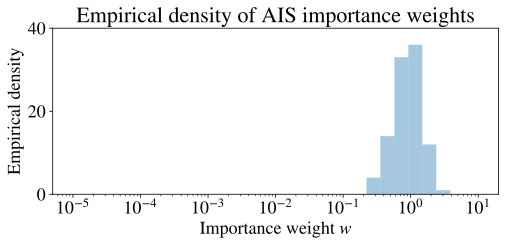

In [62]:
# Plot distributions and samples
plt.figure(figsize=(8, 3))

# Plot importance weights
plt.hist(
    tf.math.exp(log_w),
    density=False,
    color="tab:blue",
    alpha=0.4,
    bins=10**tf.linspace(-5., 1.0, 30),
    zorder=2,
)

plt.title("Empirical density of AIS importance weights", fontsize=22)

plt.xlabel("Importance weight $w$", fontsize=18)
plt.ylabel("Empirical density", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks([0, 20, 40], fontsize=18)

plt.xscale("log")

plt.show()

As expected, most of the AIS importance weights are close to $1$.
Further, they have a clearly smaller variance than standard importance sampling.
This has a significant impact on the variance of AIS estimates.
In the running example integral we've been using thus far, AIS reduces the variance of our Monte Carlo estimate by a factor of $\approx 6$ over standard importance sampling, and gets close to the variance of an estimator that uses direct i.i.d. samples from $p$:

In [63]:
# How many samples to draw
num_samples = 100
num_trials = 100
    
# Draw samples
samples_and_log_weights = [sampler(num_samples=num_samples)[1] for _ in range(num_trials)]
samples_and_log_weights = tf.stack(samples_and_log_weights, axis=0)

samples = samples_and_log_weights[:, :, 0]
log_weights = samples_and_log_weights[:, :, 1]

w = tf.math.exp(log_weights)

# Compute importance weights and importance weighted integral
I = tf.reduce_mean(w * f(samples), axis=1)

mean_I = tf.reduce_mean(I)
std_I = tf.math.reduce_std(I)

print(
    f"Annealed Importance Sampling over {num_trials} trials "
    f"I = {mean_I:.2f} +/- {2.*std_I:.3f}."
)

Annealed Importance Sampling over 100 trials I = 0.02 +/- 2.198.


## Conclusion

In importance sampling, using a proposal distribution that is significantly different from the target distribution results in a large variance of the resulting importance weights.
Large variance in the importance weights typically induces large variance in downstream estimates obtained using these weights.
AIS is a method which helps address this issue.
AIS introduces a sequence of annealed distributions, which interpolate between the target and proposal distribution, iteratively transforming samples from the proposal distribution using a sequence of Markov transition kernels which preserve the interpolating (annealed) distributions.
In this way, AIS typically reduces the variance in the importance weights, which in turn reduces the variance in downstream Monte Carlo estimates.
For more details, Radford Neal's original paper introducing AIS{cite}`neal2001annealed` is a classic worth reading.

## References

:::{bibliography}
:filter: docname in docnames

:::